In [1]:
import pandas as pd
import numpy as np
from sklearn import model_selection,metrics
from tqdm import tqdm_notebook
import lightgbm as lgb
import matplotlib.pyplot as plt
%matplotlib inline
import deepdish as dd

import gc
import os
import logging
import datetime
import warnings
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')
from bayes_opt import BayesianOptimization
import random
import pickle


In [2]:
os.listdir('/home/fshare_rb/rb/CAR/plans/')

['CAR_external.h5',
 'CAR_hard.h5',
 'CAR_hard_with_names.h5',
 'CAR_hcc.h5',
 'CAR_odkp.h5']

In [3]:
# загружаем данные
CAR = dd.io.load('/home/fshare_rb/rb/CAR/plans_new/CAR_with_names_and_preds.h5')

In [4]:
# CAR_names = dd.io.load('/home/fshare_rb/rb/CAR/plans/CAR_hard_with_names.h5')
# CAR_names = CAR_names.groupby(['date','ac13_orig','ptdtn']).last().reset_index()

In [5]:
# CAR = CAR.merge(CAR_names[['date','ac13_orig','ptdtn','hard_name']],on = ['date','ac13_orig','ptdtn'],how='left')column

In [6]:
# смотрим размер данных
CAR.shape

(1118919, 174)

In [7]:
#выбираем нужные даты
dates = pd.date_range(start='2016-06-01',end='2018-11-01',freq='M')
dates_list = [date + pd.Timedelta(days=1) for date in dates]
# dates_list

In [8]:
# составялем списки фичей
stcols = CAR.columns[CAR.columns.str.startswith('20')]
target_cols = CAR.columns[CAR.columns.str.contains('coll_ov_\d')]
debt_cols= list(CAR.columns[CAR.columns.str.startswith('PT')])
non_feat = ['ac13_orig','ptdtn','ac13','date', 'delay_beg', 'id_cl','dpd_bucket','VAR_bucket','HUB','pmt_exec_date','coll_total']
features = [c for c in CAR.columns if c not in debt_cols+ non_feat+list(stcols)+list(target_cols)+['target']]

In [9]:
#  Генерируем новые фичи

In [12]:
CAR['prob_th'] = CAR['prob'].apply(lambda x: 1 if x >0.5 else x)
CAR['old_pred'] = CAR['prob_th'] * CAR['predictions'] 
CAR['prob_0'] = pd.get_dummies(CAR['prob_th'])[0.0]
CAR['prob_1'] = pd.get_dummies(CAR['prob_th'])[1.0]

In [13]:
fact_sum=CAR.groupby(['clean_name','date'])['fact'].sum().reset_index()['fact']
portfel=CAR.groupby(['clean_name','date'])['fact'].size().reset_index()['fact']
sum_1 = CAR.groupby(['clean_name','date'])['prob_1'].sum().reset_index()['prob_1']
sum_0 = CAR.groupby(['clean_name','date'])['prob_0'].sum().reset_index()['prob_0']
old_pred = CAR.groupby(['clean_name','date'])['old_pred'].sum().reset_index()['old_pred']

In [14]:
CAR =  CAR.groupby(['clean_name','date']).mean().reset_index()

In [15]:
CAR["fact_sum"]=fact_sum
CAR["portfel"]=portfel
CAR["old_pred"]=old_pred
CAR["sum_1"]=sum_1 
CAR["sum_0"]=sum_0 

In [16]:
#  заполняем список фичей
features = [c for c in CAR.columns if c not in debt_cols+ non_feat+list(stcols)+list(target_cols)+['target','rb_plan_sum','rb_plan','CAR_index']+
            ['clean_name','date']+['fact_sum','fact','index']]


In [17]:
features

['CLIENT_CATEGORY_BUDGET_Bona-fide',
 'CLIENT_CATEGORY_BUDGET_Depositors',
 'CLIENT_CATEGORY_BUDGET_Payroll',
 'CLIENT_CATEGORY_BUDGET_Walk-in',
 'HUB_ДАЛЬНЕВОСТОЧНАЯ',
 'HUB_МОСКОВСКАЯ',
 'HUB_ПРИВОЛЖСКАЯ',
 'HUB_СЕВЕРО-ЗАПАДНАЯ',
 'HUB_СИБИРСКАЯ',
 'HUB_ЮЖНАЯ',
 'PRODUCT_ENG8N_BIG money',
 'PRODUCT_ENG8N_CAR-classic',
 'PRODUCT_ENG8N_CAR-express',
 'PRODUCT_ENG8N_CARD with grace period',
 'PRODUCT_ENG8N_Corporate',
 'PRODUCT_ENG8N_ECLoan',
 'PRODUCT_ENG8N_FormerLoan(PRO)',
 'PRODUCT_ENG8N_MORTGAGE',
 'PRODUCT_ENG8N_OTHER',
 'PRODUCT_ENG8N_OVERDRAFT on cards',
 'PRODUCT_ENG8N_PROFESSIONAL(PRO)',
 'PRODUCT_ENG8N_PROFESSIONAL+(PRO)',
 'PRODUCT_ENG8N_SIMPLE money',
 'active_credits',
 'car_credit_y',
 'cbr_minus_month_1',
 'cbr_minus_month_2',
 'cbr_minus_month_3',
 'coll_ov_-15',
 'coll_ov_-15_num',
 'coll_ov_-180',
 'coll_ov_-180_num',
 'coll_ov_-7',
 'coll_ov_-7_num',
 'coll_ov_-90',
 'coll_ov_-90_num',
 'coll_ov_minus_month_1',
 'coll_ov_minus_month_1_num',
 'coll_ov_minus_month_2',


In [18]:
#  подбираем параметры для  LGBM
param_reg= {
    'lambda_l1': 10,
    'lambda_l2': 10,
    'bagging_freq': 1,
    'bagging_fraction': 0.99999,
    'boost_from_average':False,
    'boost': 'gbdt',#'gbdt',#
    'feature_fraction':0.9999,
    'learning_rate': 0.005,
    'max_depth': 5,
    'metric':'rmse',
    'min_data_in_leaf': 20,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 20,
#     'num_threads': 12,
    'tree_learner': 'serial',
    'verbosity': 1,
}

In [19]:
dates = pd.date_range(start='2016-07-01',end='2018-11-01',freq='M')

In [20]:
dates = pd.date_range(start='2018-01-01',end='2018-11-01',freq='M')

In [21]:
# CAR['fact'][CAR['fact']<20000].plot(kind='hist')

In [22]:

def my_err(pred,val_data):
    
    print('my_err:',len(pred))
    real_mape = np.abs(val_data.get_label()-train_df_reg['portfel']*pred)/val_data.get_label()*100
    
    return 'myloss',  real_mape, False

In [23]:
# функция для метрики MAAPE

EPSILON = 1e-10

def maape(predicted,actual):

    actual = actual.get_label()

    """
    Mean Arctangent Absolute Percentage Error
    Note: result is NOT multiplied by 100

    """
    return 'myloss',np.mean(np.arctan(np.abs((actual - predicted) / (actual + EPSILON)))), False


In [24]:
#  создаем новую переменная переводя вероятности в бинарный вид с порогом 0.5
CAR['new_pred_prob'] =  CAR["prob"].apply(lambda x : 1  if x >0.5 else x) * CAR["predictions"]

In [32]:
# target_col = 'coll_ov_30_num'
target_col = 'fact' #'fact'#  

results_dict = {}
mapes = []
old_mapes=[]
r_m=[]
mapes_cbr = []
m=[]
mrb=[]
pred_old=0
n=0
prev_date = None
for date in dates:
    result_dict = {}
    date = date + pd.Timedelta(days=1)
    print(date)

   
    #regression 
    CAR['target'] = CAR[target_col].fillna(0)
    CAR[(CAR.target<=0)].target = 0
#     CAR[(CAR.target>20000)].target = 20000
    CAR.target = CAR.target#*100000
    
#     print(CAR.shape)

    train_df_reg = CAR[(CAR.date<date)&
                  (CAR.target>0)]
    test_df_reg =  CAR[(CAR.date==date)&
                  (CAR.target>0)]
    
    
    print(train_df_reg.shape,test_df_reg.shape)
#     print("train date:",train_df_reg.date.unique())
#     print("test date:",test_df_reg.date.unique())
    predictions_reg = np.zeros(len(test_df_reg))
    
    trn_data = lgb.Dataset(train_df_reg[features], label=train_df_reg.target.values,feature_name=features)
    val_data = lgb.Dataset(test_df_reg[features], label=test_df_reg.target.values,feature_name=features)
    num_round = 50000
    clf_reg = lgb.train(param_reg, trn_data, num_round, valid_sets = [trn_data, val_data],
                    verbose_eval=1000, early_stopping_rounds = 0,feval = maape)#,feval=r2_score_lgbm)
    
    fold_importance_df_reg = pd.DataFrame()
    fold_importance_df_reg["Feature"] = features
    fold_importance_df_reg["importance"] = clf_reg.feature_importance()
    predictions_reg = clf_reg.predict(test_df_reg[features], num_iteration=clf_reg.best_iteration)
    
    print('===========================')
    print("{} RMSE score: {:<8.5f}".format(str(date)[:10],
                                           np.sqrt(metrics.mean_squared_error(test_df_reg.target.values, predictions_reg))))
    print('===========================')    

    # RESULTS
    pred_r = clf_reg.predict(test_df_reg[features],num_iteration=clf_reg.best_iteration)
#     print((2/(n+2)))
#     print(len(pred_r),pred_old)
    test_df_reg['pred_reg'] = pred_r#(2/(n+2))*pred_r + (1-2/(n+2))*pred_old
#     pred_old = pred_r
#     n+=1
        
    result = test_df_reg.merge(test_df_reg[['clean_name','date']],
                        on=['clean_name','date'],how='left')
    result[result[target_col]<0][target_col] = 0
    
    
    fact = result[target_col].sum()
    
   
    
    old_pred = test_df_reg['predictions'].sum()
    predictions = result.pred_reg.sum()
    mape = np.abs(fact-predictions)*100/fact
    old_mape = np.abs(fact-old_pred)*100/fact
    mapes.append(mape)
    old_mapes.append(old_mape)
    
    
#     print(test_df_reg['fact_sum'].mean(),test_df_reg['pred_reg'].mean())
#     real_mape = np.abs(test_df_reg['fact_sum']-test_df_reg['pred_reg'])/test_df_reg['fact_sum']*100
#     real_mape=real_mape.mean()
#     r_m.append(real_mape)

    pred_sum=test_df_reg['portfel']*test_df_reg['pred_reg']
    test_df_reg['prob_th'] = test_df_reg['prob'].apply(lambda x: 1 if x >0.1 else x)

    real_mape = np.abs(test_df_reg['fact_sum']-test_df_reg['pred_reg']*test_df_reg['portfel'])/test_df_reg['fact_sum']*100
    real_mape[real_mape > 300]=300
    real_mape=real_mape.mean()

    r_m.append(real_mape)
    
    
    
    mape = np.abs(test_df_reg['fact_sum']-(test_df_reg['prob_th'])*test_df_reg['predictions']*test_df_reg['portfel'])/test_df_reg['fact_sum']*100
    mape[mape > 300]=300
    mape=mape.mean()

    m.append(mape)
    
    
    print('\n++++++++++++++++++++++++++++++++++')
    print('{} Real_Mape: {}'.format(str(date)[:10],real_mape))
    print('Cumulative Real_Mape: {}'.format(np.mean(r_m)))
    print('++++++++++++++++++++++++++++++++++++')
    print('\n++++++++++++++++++++++++++++++++++')
    print('{} Base_Mape: {}'.format(str(date)[:10],mape))
    print('Cumulative Base_Mape: {}'.format(np.mean(m)))
    print('++++++++++++++++++++++++++++++++++++')

    result_dict['index'] = test_df_reg.index
    result_dict['fact'] = result[target_col].fillna(0)
#     result_dict['rb_plan_sum'] = test_df_reg['rb_plan_sum']
    result_dict['pred_s'] = test_df_reg['pred_reg']*test_df_reg['portfel']
    result_dict['fact_s'] = test_df_reg['fact_sum']
    
    result_dict['predictions'] = result.pred_reg
    result_dict['mape'] = mape
    
    results_dict[str(date)[:10]] = result_dict
    

#     model_name = 'id_PLAN_HARD' + '_results_dict_month.pickle'
    
#     with open(model_name, 'wb') as f:
#         pickle.dump(results_dict,f)

2018-02-01 00:00:00
(3850, 142) (191, 142)
Training until validation scores don't improve for 0 rounds.
Early stopping, best iteration is:
[175]	training's rmse: 10475.2	training's myloss: 0.42437	valid_1's rmse: 5987.87	valid_1's myloss: 0.409446
2018-02-01 RMSE score: 5987.86623

++++++++++++++++++++++++++++++++++
2018-02-01 Real_Mape: 49.307443277115226
Cumulative Real_Mape: 49.307443277115226
++++++++++++++++++++++++++++++++++++

++++++++++++++++++++++++++++++++++
2018-02-01 Base_Mape: 65.12848453545891
Cumulative Base_Mape: 65.12848453545891
++++++++++++++++++++++++++++++++++++
2018-03-01 00:00:00
(4041, 142) (190, 142)
Training until validation scores don't improve for 0 rounds.
Early stopping, best iteration is:
[181]	training's rmse: 10174	training's myloss: 0.424033	valid_1's rmse: 7058.83	valid_1's myloss: 0.384215
2018-03-01 RMSE score: 7058.83090

++++++++++++++++++++++++++++++++++
2018-03-01 Real_Mape: 45.560911147663255
Cumulative Real_Mape: 47.434177212389244
+++++++++++

In [26]:
result_dict.keys()

dict_keys(['fact_s', 'mape', 'fact', 'predictions', 'pred_s', 'index'])

In [31]:
# dates

DatetimeIndex(['2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30',
               '2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31',
               '2018-09-30', '2018-10-31'],
              dtype='datetime64[ns]', freq='M')

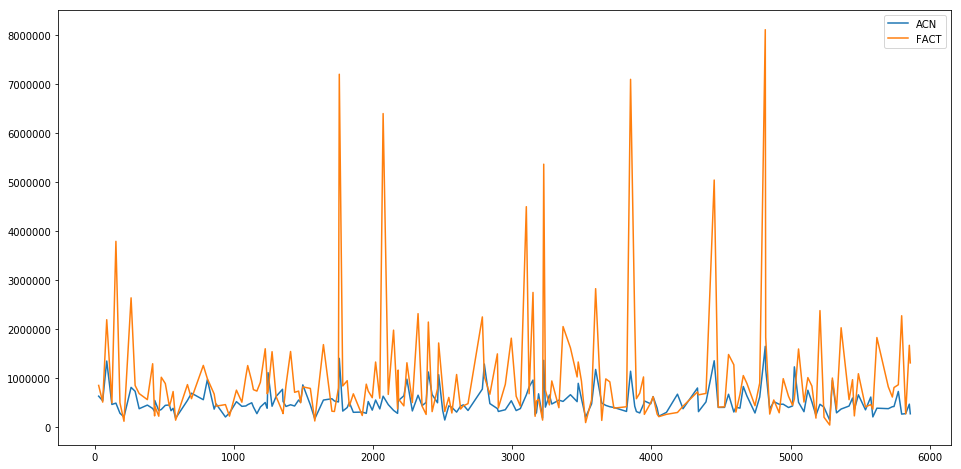

In [27]:
pd.DataFrame({'ACN':result_dict['pred_s'],'FACT':result_dict['fact_s']}).plot(figsize=(16,8))


In [28]:
features=[]
for i,j in sorted(zip(fold_importance_df_reg.importance,fold_importance_df_reg.Feature))[-20:]:
    print(j)
    features.append(j)

coll_total_minus_month_1_num
car_credit_y
21350.0_time_dif
VAR_bucket_mean
coll_ov_minus_month_3_num
sum_0
coll_ov_minus_month_1_num
predictions
active_credits
coll_ov_-180_num
CLIENT_CATEGORY_BUDGET_Bona-fide
irat
coll_ov_minus_month_3
blend
21077.0_time_dif
pred_reg
PRODUCT_ENG8N_MORTGAGE
prob_orig
ptsum
portfel


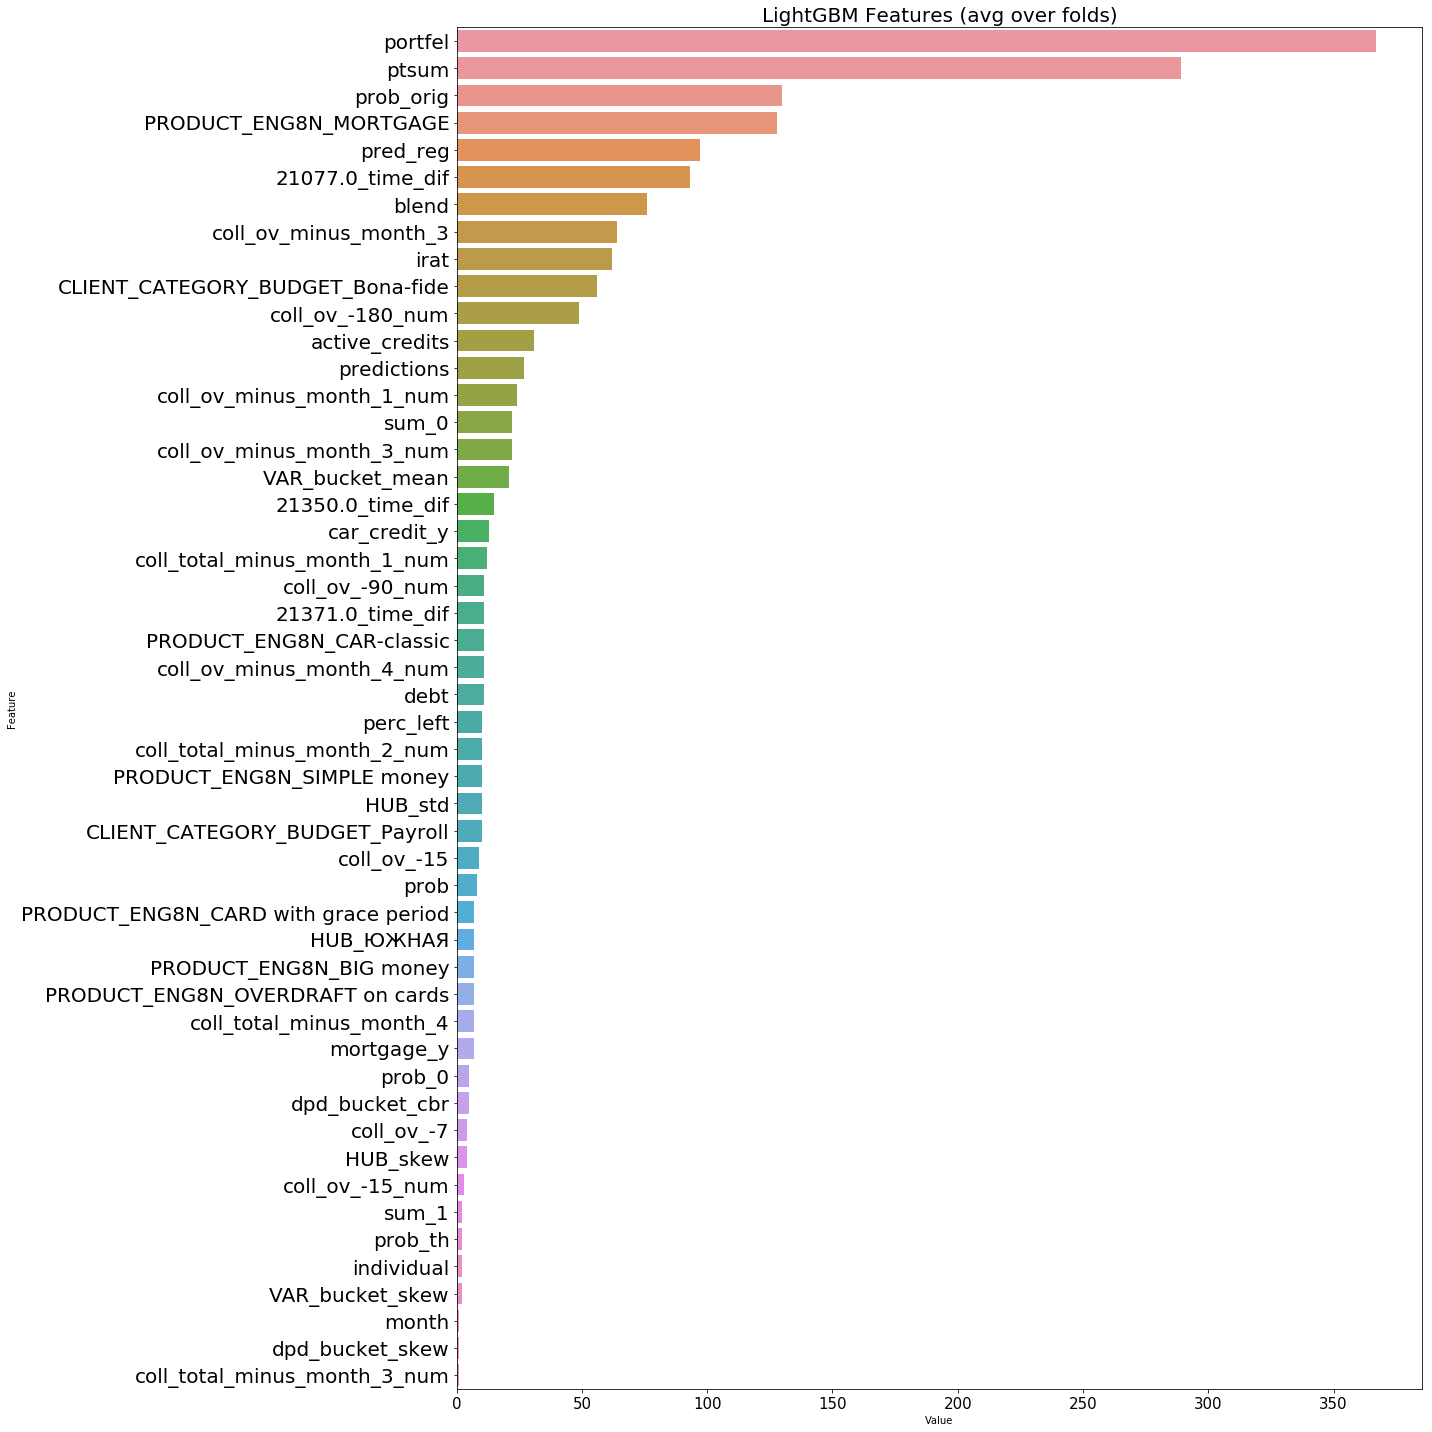

In [29]:
# выведем важные переменные
feature_imp = pd.DataFrame(sorted(zip(fold_importance_df_reg.importance,fold_importance_df_reg.Feature))[:], columns=['Value','Feature'])

plt.figure(figsize=(20, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:50])
plt.title('LightGBM Features (avg over folds)',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=20)

plt.tight_layout()
# plt.savefig("top50_features_cls.png")
plt.show()

In [409]:
fold_importance_df_reg.to_excel('2405Features_imp.xls',index=False)